<a href="https://colab.research.google.com/github/dqminhv/fraudulent-job-posting-detection-with-NLP/blob/main/notebook/data-preprocessing-and-modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Preprocessing

## Import required packages

In [16]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer
from sklearn.metrics import classification_report, precision_score, recall_score, roc_curve, auc, f1_score
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPClassifier

#Import classifiers
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier

import nltk
#nltk.download('stopwords')
#nltk.download('punkt')
#nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re

In [17]:
from from_root import from_root
import os
#Load csv file to a pandas DataFrame
job_posting_us_file = os.path.join(from_root(), "data/job-posting-us.csv")

try:
    job_posting_us_df = pd.read_csv(job_posting_us_file)
    print(job_posting_us_df.head())
except FileNotFoundError:
    print(f"Error: File not found: {job_posting_us_file}")

                                               title             location  \
0                                   marketing intern     us, ny, new york   
1                  account executive - washington dc   us, dc, washington   
2                                bill review manager   us, fl, fort worth   
3            customer service associate - part time       us, az, phoenix   
4  asp.net developer job opportunity at united st...  us, nj, jersey city   

      department   salary_range  \
0      marketing  not specified   
1          sales  not specified   
2  not specified  not specified   
3  not specified  not specified   
4  not specified  100000-120000   

                                     company_profile  \
0  we're food52, and we've created a groundbreaki...   
1  our passion for improving quality of life thro...   
2  spotsource solutions llc is a global human cap...   
3  novitex enterprise solutions, formerly pitney ...   
4                                      not spe

In [18]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dqmin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\dqmin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\dqmin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## Create a text cleaning function

In [19]:
#Create a function to clean the text feature
stop=set(stopwords.words("english"))

def clean(text):
    text=text.lower()
    obj=re.compile(r"<.*?>")                     #removing html tags
    text=obj.sub(r" ",text)
    obj=re.compile(r"https://\S+|http://\S+")    #removing url
    text=obj.sub(r" ",text)
    obj=re.compile(r"[^\w\s]")                   #removing punctuations
    text=obj.sub(r" ",text)
    obj=re.compile(r"\d{1,}")                    #removing digits
    text=obj.sub(r" ",text)
    obj=re.compile(r"_+")                        #removing underscore
    text=obj.sub(r" ",text)
    obj=re.compile(r"\s\w\s")                    #removing single character
    text=obj.sub(r" ",text)
    obj=re.compile(r"\s{2,}")                    #removing multiple spaces
    text=obj.sub(r" ",text)
    lemmatizer = WordNetLemmatizer()
    text=[lemmatizer.lemmatize(word) for word in text.split() if word not in stop]
    return " ".join(text)

## Turning int variable to text

In [20]:
job_posting_us_df['telecommuting'] = job_posting_us_df['telecommuting'].astype(str)
job_posting_us_df.loc[job_posting_us_df.telecommuting == 1, 'telecommuting'] = 'telecommuting'
job_posting_us_df.loc[job_posting_us_df.telecommuting == 0, 'telecommuting'] = 'no-telecommuting'

job_posting_us_df['has_company_logo'] = job_posting_us_df['has_company_logo'].astype(str)
job_posting_us_df.loc[job_posting_us_df.has_company_logo == 1, 'has_company_logo'] = 'has-logo'
job_posting_us_df.loc[job_posting_us_df.has_company_logo == 0, 'has_company_logo'] = 'no-logo'

job_posting_us_df['has_questions'] = job_posting_us_df['has_questions'].astype(str)
job_posting_us_df.loc[job_posting_us_df.has_questions == 1, 'has_questions'] = 'has-questions'
job_posting_us_df.loc[job_posting_us_df.has_questions == 0, 'has_questions'] = 'no-question'

## Create a text feature by combining all the columns

In [21]:
#Combine all features into one column
job_posting_us_df["text"]=""
for col in job_posting_us_df.drop('fraudulent', axis=1).columns:
    job_posting_us_df["text"]=job_posting_us_df["text"]+" "+job_posting_us_df[col]

In [22]:
job_posting_us_df['text'].apply(clean)

0       marketing intern u ny new york marketing speci...
1       account executive washington dc u dc washingto...
2       bill review manager u fl fort worth specified ...
3       customer service associate part time u az phoe...
4       asp net developer job opportunity united state...
                              ...                        
6747    post production editor u ia west de moines spe...
6748    senior financial analyst retail u ca gardena s...
6749    product manager u ca san francisco product dev...
6750    javascript developer u specified specified sr ...
6751    payroll accountant u pa philadelphia accountin...
Name: text, Length: 6752, dtype: object

# Modeling

**1. Models**



Given the imbalanced nature of the dataset and the task of classifying fraudulent job postings based on job descriptions, several classification algorithms can be considered. However, algorithms that handle class imbalance well and are robust to noisy data are typically preferred. Here are some algorithms that you may want to consider:

- **Random Forest**: Random Forest is an ensemble learning algorithm that works well with imbalanced datasets. It builds multiple decision trees and combines their predictions to improve accuracy.

- **Gradient Boosting Machines (GBM)**: GBM algorithms like XGBoost, LightGBM, and CatBoost are also effective for imbalanced classification tasks. They sequentially build multiple weak learners to minimize a loss function, which often leads to better performance on imbalanced datasets.

- **Support Vector Machines (SVM)**: SVM is a powerful algorithm for binary classification tasks. By adjusting the hyperparameters, such as the regularization parameter (C) and the kernel function, SVM can be effective for imbalanced data.

- **Logistic Regression**: Despite its simplicity, logistic regression can perform well on imbalanced datasets, especially when combined with techniques like class weighting or penalization.

- **AdaBoost**: AdaBoost is an ensemble learning algorithm that combines multiple weak classifiers to create a strong classifier. It is known to perform well on imbalanced datasets.

- **Neural Networks**: Deep learning models, such as neural networks, can also be effective for imbalanced classification tasks, especially when dealing with large datasets. Architectures like Convolutional Neural Networks (CNNs) or Recurrent Neural Networks (RNNs) can capture complex patterns in text data.

- **Naive Bayes**: Despite its simplicity and assumption of feature independence, Naive Bayes can perform surprisingly well on text classification tasks, including imbalanced datasets.

**2. Metrics**

For a fraud detection problem with an imbalanced dataset where the non-fraudulent class comprises 90% of the dataset, we use F1 score to evaluate the performance of the model. We want to maximize the True Positive Rate, which means we want to catch all the fraudulent job postings, but we also want to minimize the false positive rate, which means we do not want to flag to many legit job posting as fraudulent.

**F1 Score**: The F1 score is the harmonic mean of precision and recall. It provides a balance between precision and recall and is useful when there is an imbalance between the classes in the dataset. The F1 score is calculated as 2 * (precision * recall) / (precision + recall).

## Train/Test Split

In [23]:
X = job_posting_us_df['text']
y = job_posting_us_df['fraudulent']

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

## Vectorizing text data

In [25]:
#Parameters
stop_words = 'english'
min_df = .2
max_df = .7
ngram_range=(1, 1)

In [26]:
#Using TfidfVectorizer
tfidf_vect = TfidfVectorizer(stop_words=stop_words, max_df=max_df, min_df=min_df, ngram_range=ngram_range)

## Defining classifiers

In [27]:
# Define the classifiers
classifiers = {
    "Multinomial Naive Bayes": MultinomialNB(),
    "Random Forest Classifier": RandomForestClassifier(),
    "Support Vector Classifier": SVC(probability=True),
    'Gradient Boosting Classifier' : GradientBoostingClassifier(),
    'Logistic Regression Classifier': LogisticRegression(penalty='l2', solver='liblinear'),
    'Ada Boost Classifier': AdaBoostClassifier(),
    'Neural Network Classifier': MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000)
}

## Create pipeline

In [28]:
# Create the pipeline for each classifier
pipelines = {}
for classifier_name, classifier in classifiers.items():
    pipelines[classifier_name] = Pipeline([
        ('vectorizer', tfidf_vect),
        ('classifier', classifier)
    ])

d:\Document\GitHub\fraudulent-job-posting-detection-with-NLP\venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Classifier: Multinomial Naive Bayes
Recall: 0.0
Precision: 0.0
F1 Score: 0.0
Classifier: Random Forest Classifier
Recall: 0.4020618556701031
Precision: 0.975
F1 Score: 0.5693430656934306
Classifier: Support Vector Classifier
Recall: 0.4948453608247423
Precision: 1.0
F1 Score: 0.6620689655172414
Classifier: Gradient Boosting Classifier
Recall: 0.29896907216494845
Precision: 0.9354838709677419
F1 Score: 0.453125
Classifier: Logistic Regression Classifier
Recall: 0.16494845360824742
Precision: 0.8
F1 Score: 0.27350427350427353


d:\Document\GitHub\fraudulent-job-posting-detection-with-NLP\venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Classifier: Ada Boost Classifier
Recall: 0.36082474226804123
Precision: 0.5833333333333334
F1 Score: 0.445859872611465
Classifier: Neural Network Classifier
Recall: 0.7010309278350515
Precision: 0.9066666666666666
F1 Score: 0.7906976744186046


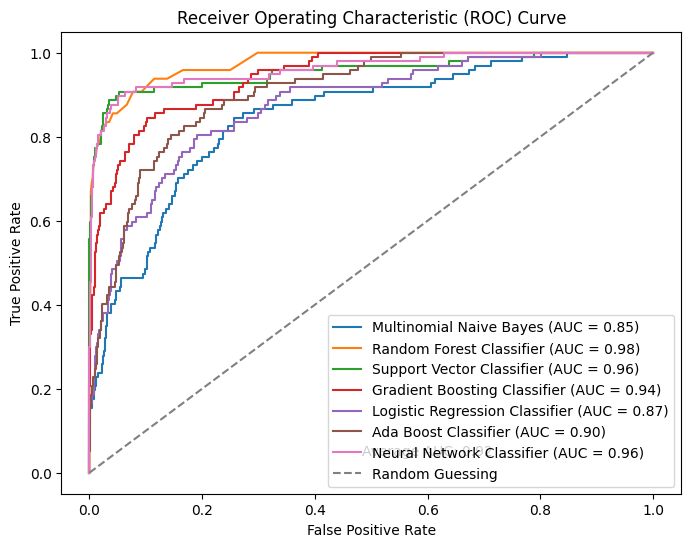

In [29]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Initialize an empty list to store ROC AUC values
roc_aucs = []

plt.figure(figsize=(8, 6))  # Adjust figure size for multiple curves

for classifier_name, pipeline in pipelines.items():
    pipeline.fit(X_train, y_train)
    predictions = pipeline.predict(X_test)
    recall = recall_score(y_test, predictions)
    precision = precision_score(y_test, predictions)
    f1 = f1_score(y_test, predictions)
    print(f"Classifier: {classifier_name}")
    print(f"Recall: {recall}")
    print(f"Precision: {precision}")
    print(f"F1 Score: {f1}")

    # Calculate fpr and tpr
    # Get predicted probabilities
    y_score = pipeline.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_score)

    # Calculate AUC
    roc_auc = auc(fpr, tpr)
    roc_aucs.append(roc_auc)  # Store AUC value

    # Plot ROC curve
    plt.plot(fpr, tpr, label=f'{classifier_name} (AUC = {roc_auc:.2f})')

# Plot ROC curve for random guessing
plt.plot([0, 1], [0, 1], linestyle='--', color='grey', label='Random Guessing')

# Set labels and title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')

# Show plot with additional information about AUC
plt.text(0.6, 0.05, f"Average AUC: {np.mean(roc_aucs):.2f}", ha='center', va='center', fontsize=10)
plt.show()


In [32]:
pipelines_MLP = Pipeline([
        ('vectorizer', tfidf_vect),
        ('classifier', MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000))
    ])

import joblib
joblib.dump(pipelines_MLP, "model_MLP.joblib")

['model_MLP.joblib']

## Model selection and Hyper-paramerters tuning

The Neural Network Classifier yield the highest F1 score. Thus, we will select this model and perform hyper-parameters tuning.

In [ ]:
from sklearn.model_selection import GridSearchCV

# Define the pipeline
pipeline = Pipeline([
    ('vectorizer', tfidf_vect),
    ('clf', MLPClassifier(max_iter=1000))
])

# Define hyperparameters and their ranges
parameters = {
    'clf__hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 100)],
    'clf__activation': ['logistic', 'relu'],
    'clf__alpha': [0.0001, 0.001, 0.01],
    'clf__learning_rate': ['constant', 'adaptive'],
}

# Define the GridSearchCV object
grid_search = GridSearchCV(pipeline, parameters, cv=5, scoring='f1', verbose=1)

# Fit the GridSearchCV object to the data
grid_search.fit(X_train, y_train)

# Print the best parameters found
print("Best parameters found:")
print(grid_search.best_params_)

# Evaluate the best model on the test set
y_pred = grid_search.predict(X_test)
print("Classification Report:")
print(classification_report(y_test, y_pred))


Fitting 5 folds for each of 48 candidates, totalling 240 fits


d:\Document\GitHub\fraudulent-job-posting-detection-with-NLP\venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
d:\Document\GitHub\fraudulent-job-posting-detection-with-NLP\venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
d:\Document\GitHub\fraudulent-job-posting-detection-with-NLP\venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:697: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


## Export Best Model

In [ ]:
import pickle

# Save the model to a file
with open(os.path.join(from_root(), "model/model.pkl"), 'rb') as file:
    pickle.dump(grid_search, file)

#import joblib
#joblib.dump(grid_search, "model.joblib")

NameError: name 'grid_search' is not defined